## Main

## Libraries

In [882]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from matplotlib.lines import Line2D
from textwrap import wrap
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.ensemble import VotingRegressor
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import RidgeCV 
from xgboost import plot_importance

## Loading The Data

In [823]:
df_concrete = pd.read_csv("train.csv").drop(columns=["id"])
print(f"Duplicates: {df_concrete.duplicated().sum():4}")
print(f"Length: {len(df_concrete)}")

Duplicates:    0
Length: 5407


## Data Familiarization

In [824]:
df_concrete.head()

,CementComponent,BlastFurnaceSlag,FlyAshComponent,WaterComponent,SuperplasticizerComponent,CoarseAggregateComponent,FineAggregateComponent,AgeInDays,Strength
0,525.0,0.0,0.0,186.0,0.0,1125.0,613.0,3,10.38
1,143.0,169.0,143.0,191.0,8.0,967.0,643.0,28,23.52
2,289.0,134.7,0.0,185.7,0.0,1075.0,795.3,28,36.96
3,304.0,76.0,0.0,228.0,0.0,932.0,670.0,365,39.05
4,157.0,236.0,0.0,192.0,0.0,935.4,781.2,90,74.19


# Feature Engineering/Data Transformations

In [825]:
'''
Some Of My Tried Features:

df_concrete['water_cement_ratio'] = (df_concrete['WaterComponent'] / df_concrete['CementComponent'])

df_concrete["TotalBinder"] = df_concrete["CementComponent"] + df_concrete["BlastFurnaceSlag"] + df_concrete["FlyAshComponent"]

from sklearn.preprocessing import PowerTransformer
pt = PowerTransformer(method="yeo-johnson")
df_concrete[["WaterComponent","SuperplasticizerComponent"]] = pt.fit_transform(df_concrete[["WaterComponent","SuperplasticizerComponent"]])

df_concrete['Age_By_Water'] = df_concrete['AgeInDays'] / df_concrete['WaterComponent']
df_concrete['Age_By_Cement'] = df_concrete['AgeInDays'] / df_concrete['CementComponent']

'''

def feature_engineering(df_concrete):
    # apply log(x+1) to age in days
    df_concrete['AgeInDays'] = df_concrete['AgeInDays'].apply(lambda x: np.log(x + 1))

    # apply log(x+1) to BlastFurnaceSlag
    df_concrete['BlastFurnaceSlag'] = df_concrete['BlastFurnaceSlag'].apply(lambda x: np.log(x + 1))

    # apply log(x+1) to FlyAshComponent
    df_concrete['FlyAshComponent'] = df_concrete['FlyAshComponent'].apply(lambda x: np.log(x + 1))

    # apply log(x+1) to SuperplasticizerComponent
    df_concrete['SuperplasticizerComponent'] = df_concrete['SuperplasticizerComponent'].apply(lambda x: np.log(x + 1))

    return df_concrete

df_concrete = feature_engineering(df_concrete)

df_concrete.head()


,CementComponent,BlastFurnaceSlag,FlyAshComponent,WaterComponent,SuperplasticizerComponent,CoarseAggregateComponent,FineAggregateComponent,AgeInDays,Strength
0,525.0,0.000000,0.000000,186.0,0.000000,1125.0,613.0,1.386294,10.38
1,143.0,5.135798,4.969813,191.0,2.197225,967.0,643.0,3.367296,23.52
2,289.0,4.910447,0.000000,185.7,0.000000,1075.0,795.3,3.367296,36.96
3,304.0,4.343805,0.000000,228.0,0.000000,932.0,670.0,5.902633,39.05
4,157.0,5.468060,0.000000,192.0,0.000000,935.4,781.2,4.510860,74.19


# Variable Explanations

Input Variables:
- CementComponent:- Amount of cement is mixed
- BlastFurnaceSlag:- Amount of Blast Furnace Slag is mixed
- FlyAshComponent:- Amount of FlyAsh is mixed
- WaterComponent:- Amount of water is mixed
- SuperplasticizerComponent:- Amount of Super plasticizer is mixed
- CoarseAggregateComponent:- Amount of Coarse Aggregate is mixed
- FineAggregateComponent:- Amount of Fine Aggregate is mixed
- AgeInDays:- How many days it was left dry

Thoughts:
- Typical water to coment ratios
    - .6 to .7 for driveways
    - .4 for higher strength areas
    - .4 ratio should equal around 5600 psi or 38 MPa
    - .8 ratio should equal around 2000 psi or 1.38 MPa

Sources/Research:
- https://concretecountertopinstitute.com/free-training/the-importance-of-water-cement-ratio-in-concrete-countertop-mix-design/?srsltid=AfmBOorH2b1lsP9YokCQJiALumlPBz4CO2-RE7y_DCqPvf0GqOLvoh5g

Target:
- Strength:- What was the final strength of concrete

## Useful Functions

In [826]:
def plot_histogram(data, rows, cols):

    _, axes = plt.subplots(rows, cols, figsize=(12, 10))

    axes = axes.flatten()

    for ax, col in zip(axes, data.columns):

        current_data = data[col]
        
        sns.histplot(current_data, kde=True, bins=30, ax=ax)
        
        mean_val = current_data.mean()
        median_val = current_data.median()
        std_val = current_data.std()
        min_val = current_data.min()
        max_val = current_data.max()

        ax.axvline(mean_val, color='r', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.2f}')
        ax.axvline(median_val, color='g', linestyle='-', linewidth=2, label=f'Median: {median_val:.2f}')
        ax.axvline(mean_val - std_val, color='b', linestyle=':', linewidth=2, label=f'Stdev: {std_val:.2f}')
        ax.axvline(mean_val + std_val, color='b', linestyle=':', linewidth=2)
        

        dummy_min = Line2D([0], [0], color='none', label=f'Min: {min_val:.2f}')
        dummy_max = Line2D([0], [0], color='none', label=f'Max: {max_val:.2f}')

        handles, labels = ax.get_legend_handles_labels()
        handles.extend([dummy_min, dummy_max])
        labels.extend([f'Min: {min_val:.2f}', f'Max: {max_val:.2f}'])
        ax.legend(handles=handles, labels=labels, loc='center left', bbox_to_anchor=(.75, .8))
        
        ax.set_title(f'Distribution of {col}')
        ax.set_xlabel(col)
        ax.set_ylabel('Frequency')

    plt.tight_layout()
    plt.savefig('df_concrete_histogram.png', bbox_inches='tight')
    plt.show()

## Descriptive Statistics

## Statistical Summary of the Data

In [827]:
df_concrete.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
CementComponent,5407.0,299.168189,105.537682,102.000000,213.700000,297.200000,375.000000,540.000000
BlastFurnaceSlag,5407.0,1.973396,2.392688,0.000000,0.000000,0.000000,4.817051,5.887215
FlyAshComponent,5407.0,1.290328,2.110588,0.000000,0.000000,0.000000,4.382027,5.303802
WaterComponent,5407.0,185.076235,18.517583,121.800000,175.100000,187.400000,192.000000,247.000000
SuperplasticizerComponent,5407.0,0.962424,1.164305,0.000000,0.000000,0.000000,2.202749,3.502550
CoarseAggregateComponent,5407.0,992.000718,77.148010,801.000000,938.200000,978.000000,1047.000000,1145.000000
FineAggregateComponent,5407.0,771.219974,78.725253,594.000000,734.300000,781.200000,821.000000,992.600000
AgeInDays,5407.0,3.312991,1.165494,0.693147,2.079442,3.367296,4.043051,5.902633
Strength,5407.0,35.452071,16.401896,2.330000,23.640000,33.950000,45.850000,82.600000


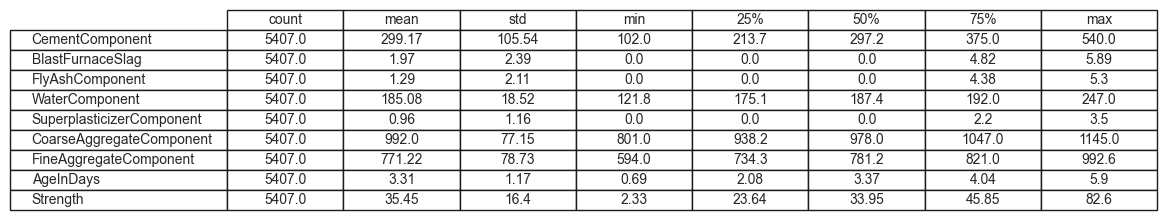

In [844]:
# Generate a descriptive summary and transpose it.
df_summary = df_concrete.describe().transpose()
df_summary['mean'] = df_summary['mean'].round(2)
df_summary['std'] = df_summary['std'].round(2)
df_summary['min'] = df_summary['min'].round(2)
df_summary['25%'] = df_summary['25%'].round(2)
df_summary['50%'] = df_summary['50%'].round(2)
df_summary['75%'] = df_summary['75%'].round(2)
df_summary['max'] = df_summary['max'].round(2)
# Create a figure and axis, and hide the axes.
fig, ax = plt.subplots(figsize=(12, 2.5))
ax.axis('off')

# Create a table from the DataFrame's values.
table = ax.table(cellText=df_summary.values,
                 colLabels=df_summary.columns,
                 rowLabels=df_summary.index,
                 cellLoc='center',
                 loc='center')

# Optionally, adjust table properties (font size, scaling, etc.)
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.0, 1.2)


# Save the table as an image file.
plt.savefig('df_concrete_summary.png', bbox_inches='tight')
plt.show()

## Distributions

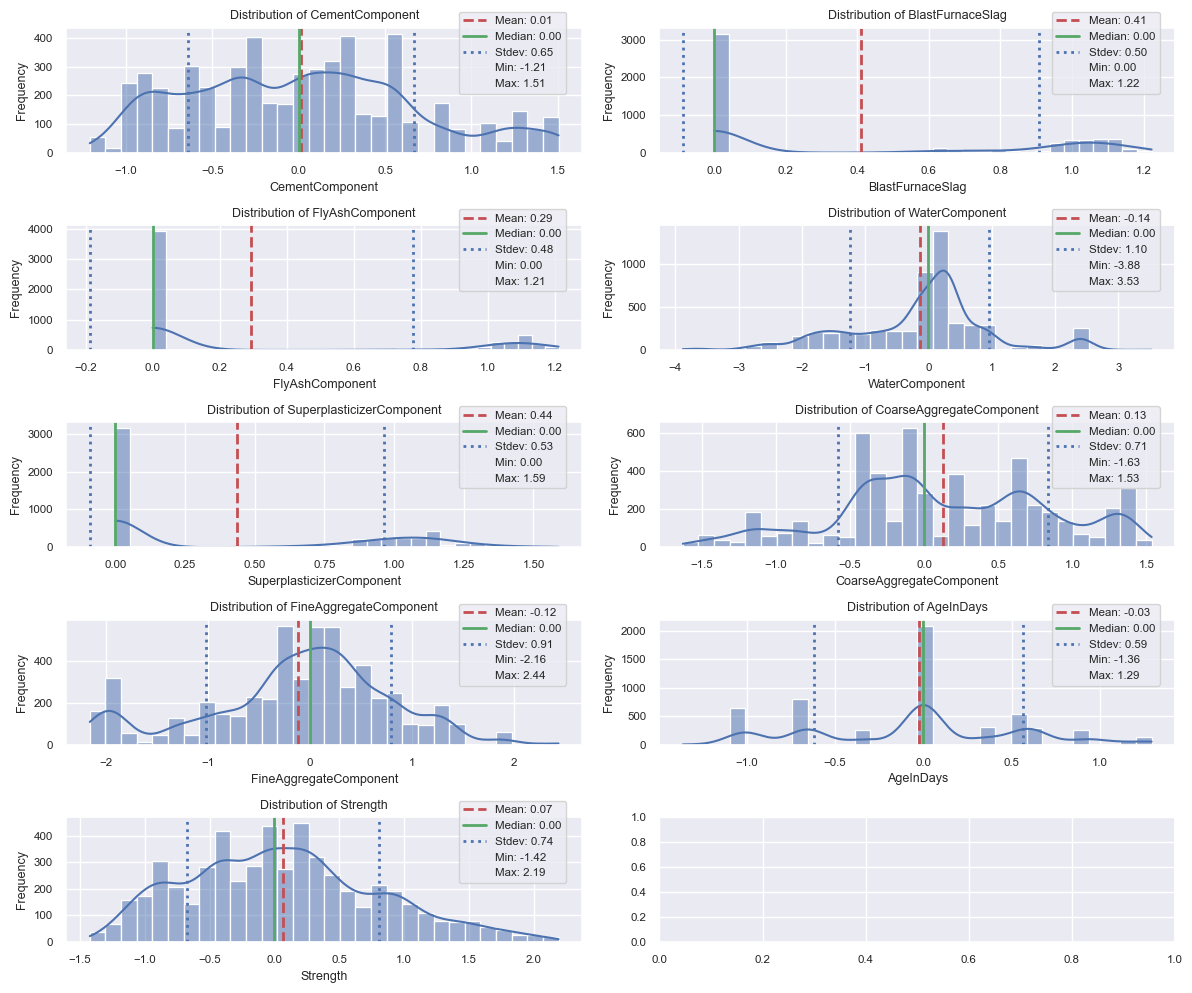

In [829]:
#df_concrete_scaled = df_concrete.copy()
#ss = StandardScaler()
#df_concrete_scaled[df_concrete.columns] = ss.fit_transform(df_concrete[df_concrete.columns])

df_concrete_robustScaled = df_concrete.copy()
rs = RobustScaler()
df_concrete_robustScaled[df_concrete.columns] = rs.fit_transform(df_concrete[df_concrete.columns])

#df_concrete_minMax = df_concrete.copy()
#mm = MinMaxScaler()
#df_concrete_minMax[df_concrete.columns] = mm.fit_transform(df_concrete[df_concrete.columns])

#plot_histogram(df_concrete, 5, 2)
#plot_histogram(df_concrete_scaled, 5, 2)
plot_histogram(df_concrete_robustScaled, 5, 2)
#plot_histogram(df_concrete_minMax, 5, 2)

## Box Plot(Outliers)

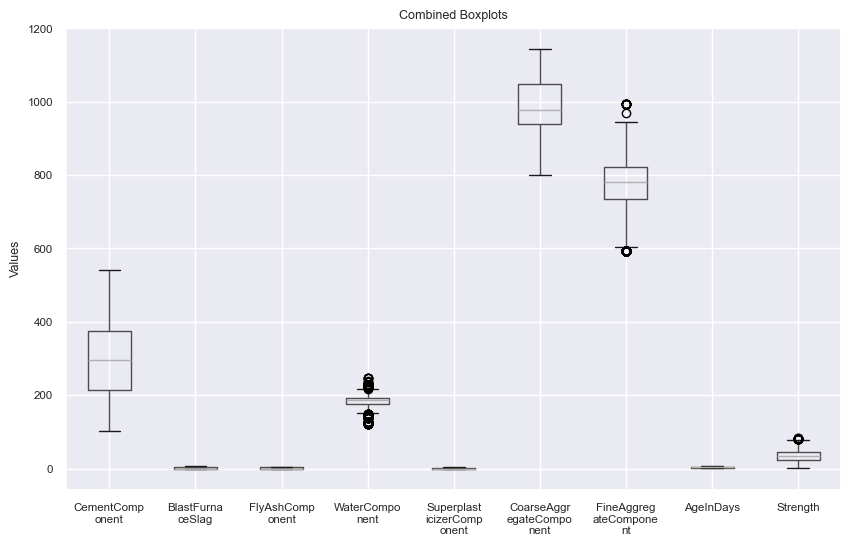

In [830]:
plt.figure(figsize=(10, 6))
ax = df_concrete.boxplot()
plt.title('Combined Boxplots')
plt.ylabel('Values')
new_labels = [
    "\n".join(wrap(label.get_text(), 10))
    for label in ax.get_xticklabels()
]
ax.set_xticklabels(new_labels, rotation=0)
plt.savefig('df_concrete_boxplot.png', bbox_inches='tight')
plt.show()

## Correlation Analysis

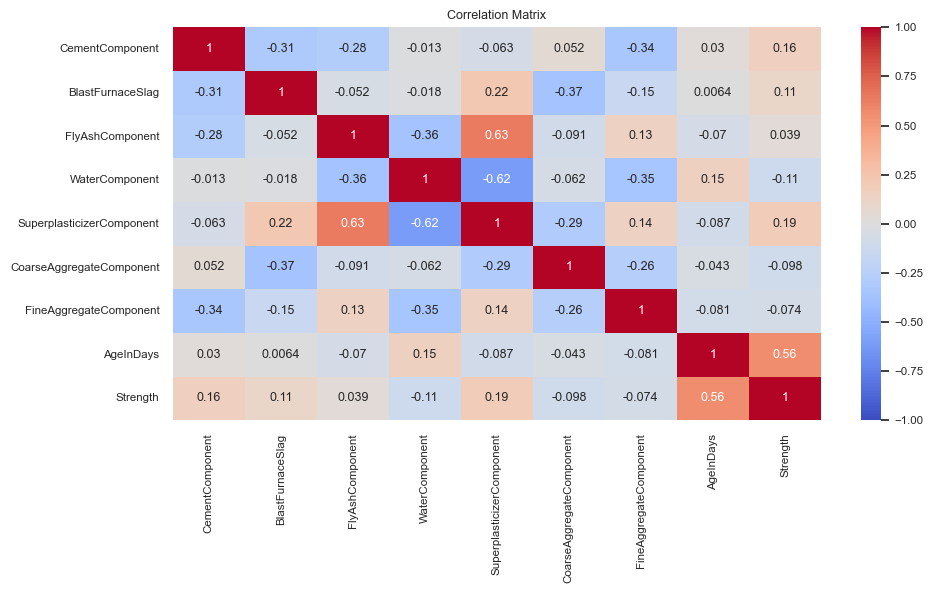

In [831]:
correlation_table = df_concrete.corr()
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_table, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.tight_layout()
plt.savefig('df_concrete_cor.png', bbox_inches='tight')
plt.show()

# Variance Inflation Factor

In [832]:
# dataset for VIF calculation
df_vif = df_concrete.copy()
df_vif = df_vif.drop(columns=["Strength"])

# build a DataFrame to hold VIF scores
vif_data = pd.DataFrame()

# exclude strength from the features
vif_data["feature"] = df_vif.columns
vif_data["VIF"] = [
    variance_inflation_factor(df_vif.values, i)
    for i in range(df_vif.shape[1])
]

# print the VIF scores
print(vif_data.sort_values("VIF", ascending=False))

                     feature        VIF
5   CoarseAggregateComponent  95.914708
3             WaterComponent  95.266146
6     FineAggregateComponent  66.423903
0            CementComponent  12.417776
7                  AgeInDays   9.287259
4  SuperplasticizerComponent   4.672273
2            FlyAshComponent   3.055554
1           BlastFurnaceSlag   2.470980


## Scatterplot Matrix

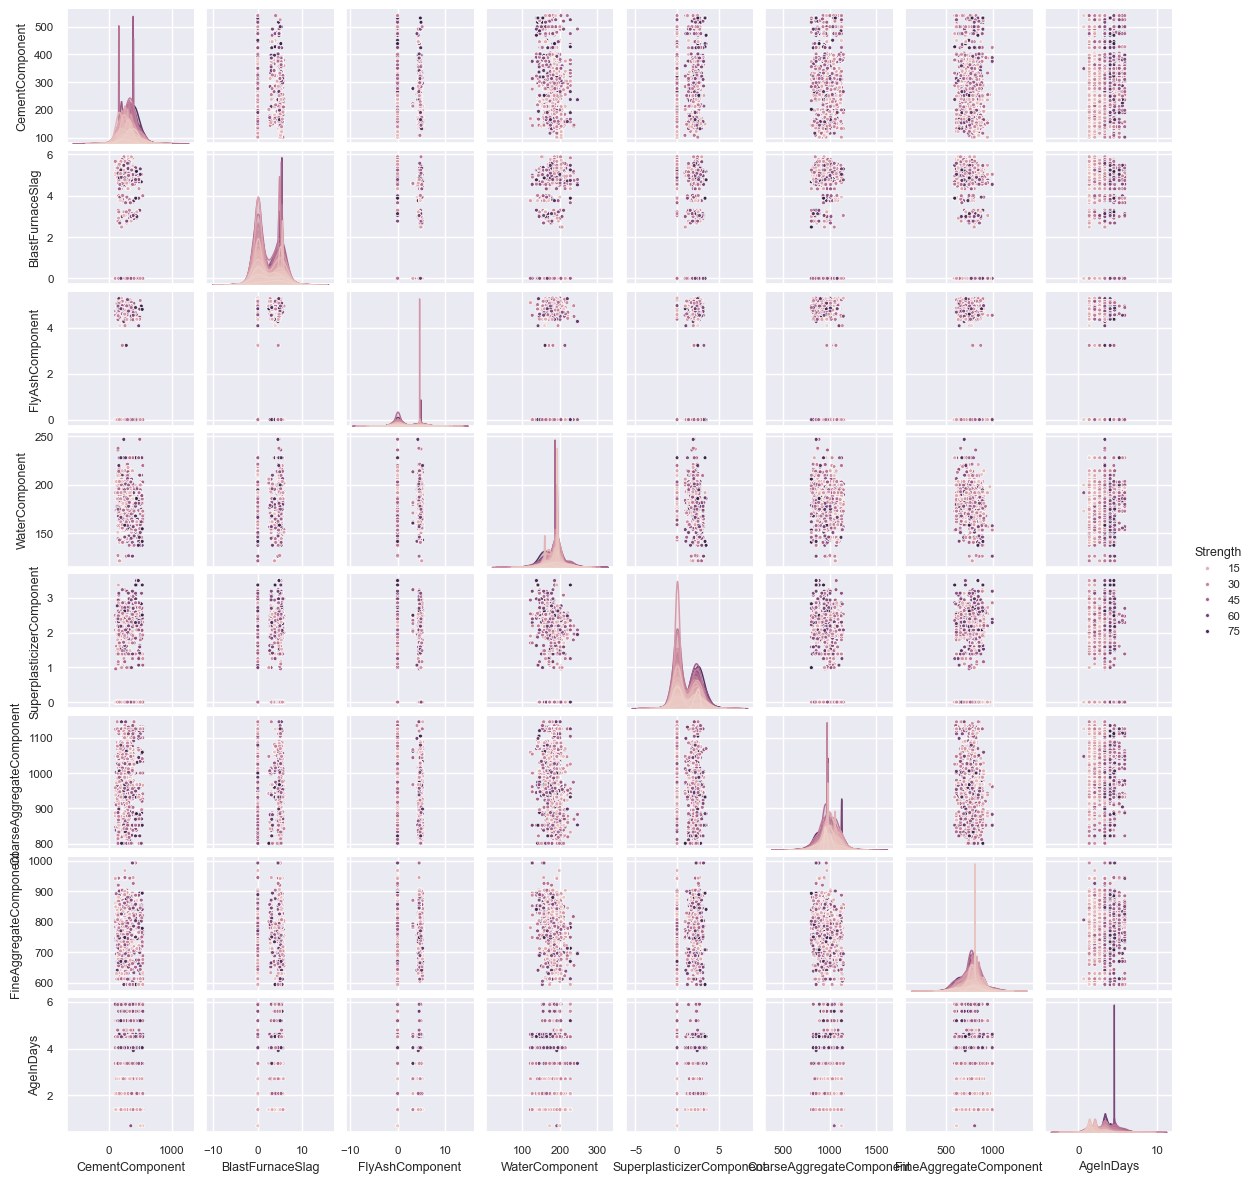

In [833]:
sns.set_theme(font_scale=0.75)
sns.pairplot(df_concrete, hue='Strength', height=1.5, markers='.', plot_kws={'s': 30}) 
plt.show()

## Baseline Model

In [834]:
X = df_concrete.drop(columns=["Strength"])
y = df_concrete["Strength"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)


## Linear Regression Baseline Model

The result of rmse is:  12.373580924070273
The result of r2 is:  0.412055434336677


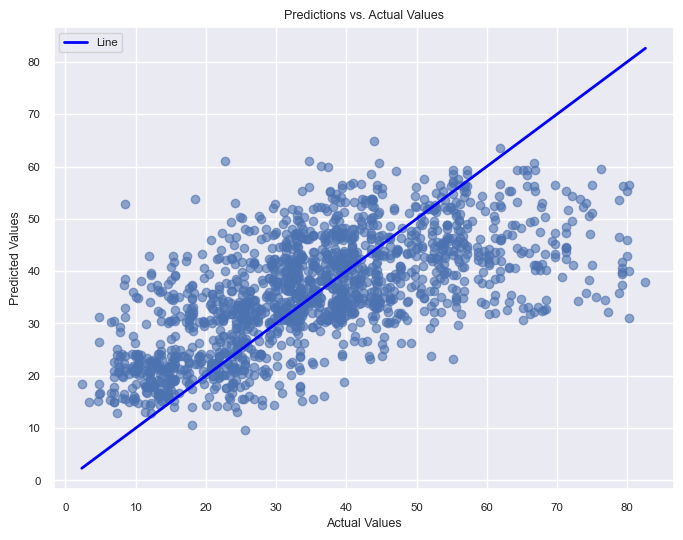

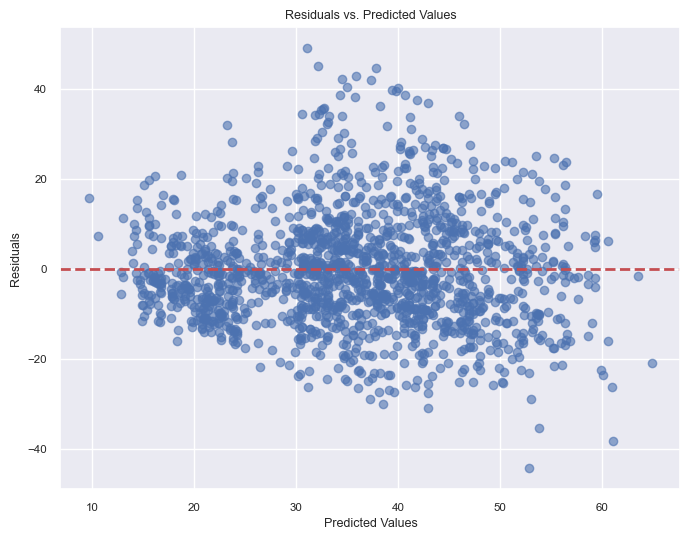

In [835]:
# linear Regression
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)
pred = model_lr.predict(X_test)
r2_score_result = r2_score(y_test, pred)
rmse = np.sqrt(np.mean((y_test - pred) ** 2))
print('The result of rmse is: ', rmse)
print('The result of r2 is: ', r2_score_result)

# plot predictions vs actual values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='blue', linestyle='-', linewidth=2, label='Line')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predictions vs. Actual Values')
plt.legend()
plt.savefig('df_concrete_r2.png', bbox_inches='tight')
plt.show()

# plot residuals
plt.figure(figsize=(8, 6))
plt.scatter(pred, y_test - pred, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Predicted Values')
plt.show()

# Loading Data Again

In [836]:
# loading the dataset again for feature engineering
train = pd.read_csv("train.csv").drop(columns=["id"])

# feature engineering
train = feature_engineering(train)

# splitting the dataset into features and target variable
X = train.drop(columns=["Strength"])
y = train["Strength"]

# splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# Linear Regression After Feature Engineering

Best estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('feature_selection',
                 SelectFromModel(estimator=Lasso(alpha=10.0, max_iter=10000),
                                 max_features=8, threshold='mean')),
                ('regressor', LinearRegression())])
Best params: {'feature_selection__estimator__alpha': 10.0, 'feature_selection__max_features': 8, 'feature_selection__threshold': 'mean'}
Test  R²:   0.411
Test RMSE: 12.883


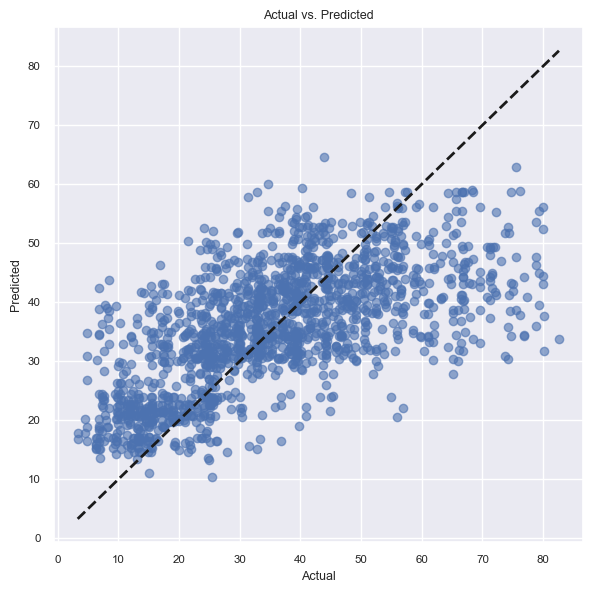

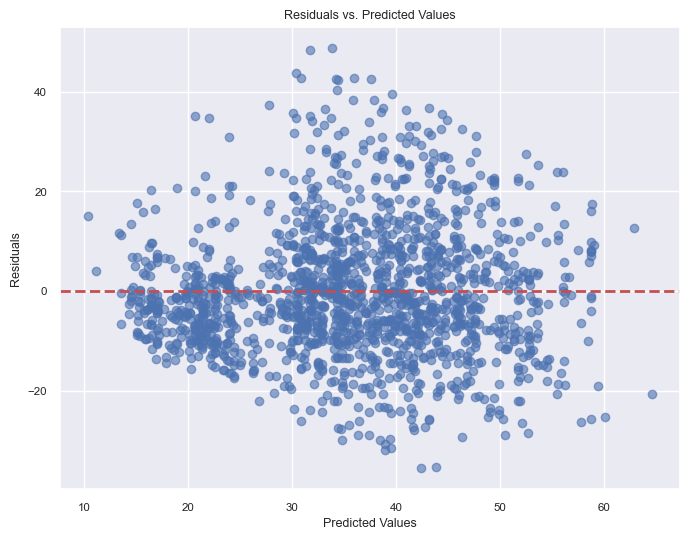

In [837]:
# define our pipeline
pipeline = Pipeline([
    # scale features to be robust to outliers
    ('scaler', RobustScaler()),  
    # use Lasso to zero-out some features
    ('feature_selection', SelectFromModel(
        estimator=Lasso(max_iter=10_000)
    )),
    # final regression model
    ('regressor', LinearRegression())
])

# set up the grid of hyperparameters to search
param_grid = {
    'feature_selection__max_features': [2, 4, 6, 8],
    'feature_selection__threshold': ['mean', 'median'],
    'feature_selection__estimator__alpha': [0.01, 0.1, 1.0, 10.0]
}

# create a grid search object
grid = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=5,                           
    n_jobs=-1  
)

# fit the grid search to the training data
grid.fit(X_train, y_train)

# print the best parameters and CV score
print("Best estimator:", grid.best_estimator_)
print("Best params:", grid.best_params_)

# eval on a hold-out test set
y_pred = grid.predict(X_test)
test_r2  = r2_score(y_test, y_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Test  R²:   {test_r2:.3f}")
print(f"Test RMSE: {test_rmse:.3f}")

# plot predicted vs. actual
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs. Predicted")
plt.tight_layout()
plt.savefig('df_concrete_r2_lin_reg_fea_data.png', bbox_inches='tight')
plt.show()

# plot residuals
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, y_test - y_pred, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Predicted Values')
plt.show()

# Gradient Boost

Best params: {'feature_selection__estimator__alpha': 10.0, 'feature_selection__max_features': 8, 'feature_selection__threshold': 'mean', 'regressor__learning_rate': 0.1, 'regressor__max_depth': 3, 'regressor__n_estimators': 100, 'regressor__subsample': 1.0}
Selected features: ['CementComponent', 'BlastFurnaceSlag', 'FlyAshComponent', 'WaterComponent', 'SuperplasticizerComponent', 'CoarseAggregateComponent', 'FineAggregateComponent', 'AgeInDays']
Test  R²:   0.455
Test RMSE: 12.394


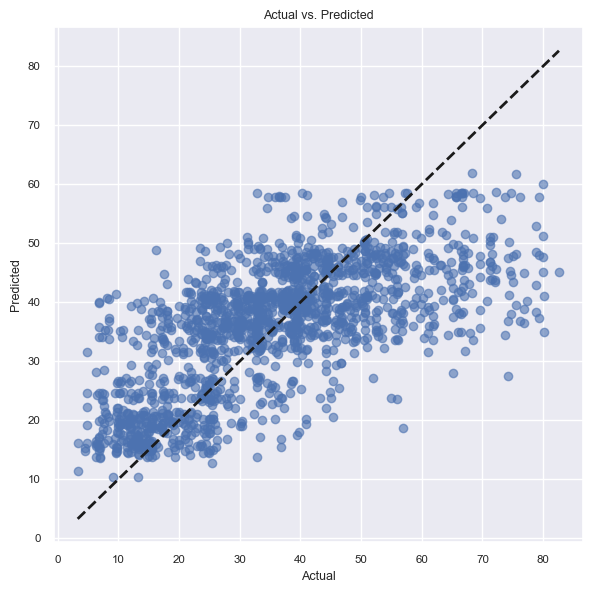

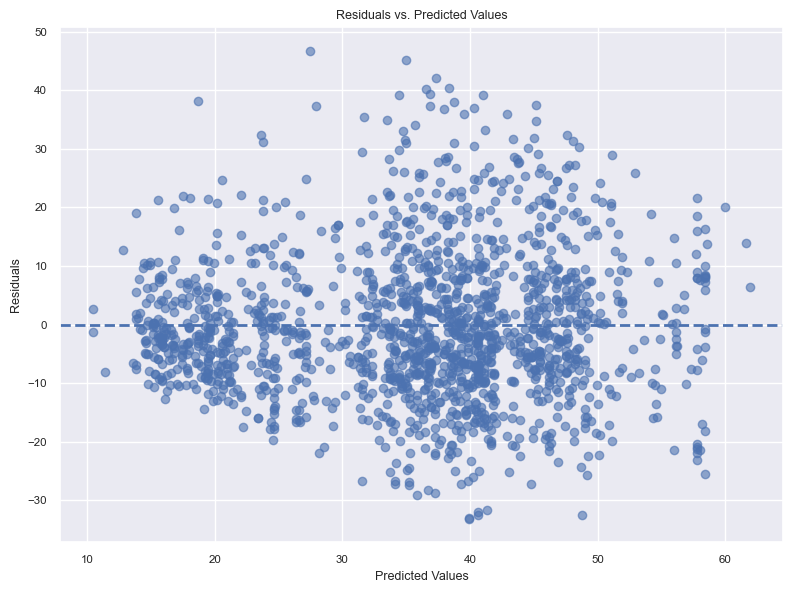

In [875]:
# define the pipeline
pipeline = Pipeline([
    ("scaler", RobustScaler()),
    ("feature_selection", SelectFromModel(
        estimator=Lasso(max_iter=10_000)
    )),
    ("regressor", GradientBoostingRegressor())
])

# set up the combined hyperparameter grid
param_grid = {
    # feature‐selector params
    "feature_selection__estimator__alpha": [0.01, 0.1, 1.0, 10.0],
    "feature_selection__threshold":     ["mean", "median"],
    "feature_selection__max_features":  [2, 4, 6, 8],

    # gradient‐boost params
    "regressor__n_estimators":    [100, 200],
    "regressor__max_depth":       [3, 5],
    "regressor__learning_rate":   [0.01, 0.1],
    "regressor__subsample":       [0.8, 1.0]
}

# wrap in a GridSearchCV
grid_gbt = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=5,
    n_jobs=-1
)

# fit on training data
grid_gbt.fit(X_train, y_train)

# print the best params
print("Best params:", grid_gbt.best_params_)

# selected features
selected_features = grid_gbt.best_estimator_.named_steps["feature_selection"].get_support(indices=True)
print("Selected features:", X.columns[selected_features].tolist())

# evaluate on test set
y_pred   = grid_gbt.predict(X_test)
test_r2  = r2_score(y_test, y_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Test  R²:   {test_r2:.3f}")
print(f"Test RMSE: {test_rmse:.3f}")

# plot actual vs. predicted
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'k--', lw=2)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs. Predicted")
plt.tight_layout()
plt.show()

# plot residuals
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, y_test - y_pred, alpha=0.6)
plt.axhline(y=0, linestyle="--", linewidth=2)
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs. Predicted Values")
plt.tight_layout()
plt.show()

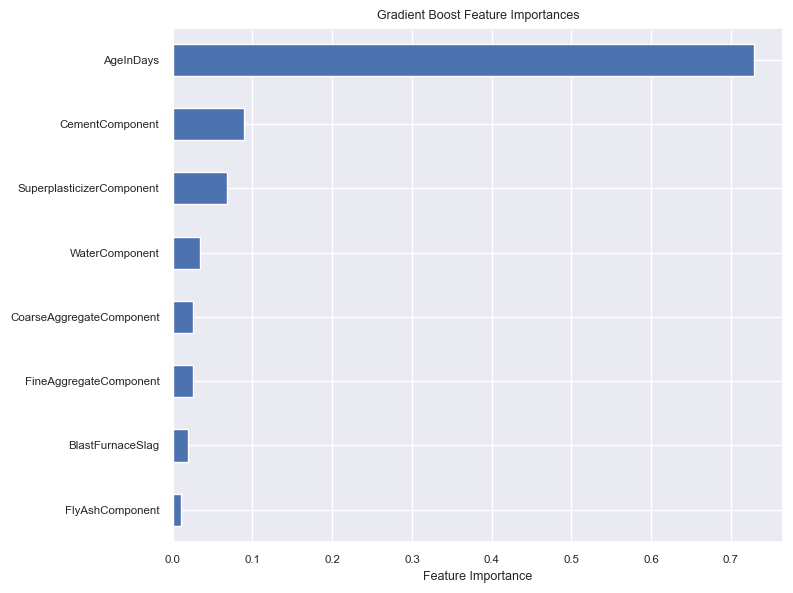

In [889]:
# getting the best fit pipeline
best_pipe = grid_gbt.best_estimator_

# pulling out the mask of selected features
support_idx = best_pipe.named_steps["feature_selection"].get_support(indices=True)
selected_feature_names = X.columns[support_idx]

# getting the fitted XGBRegressor
best_gbt = best_pipe.named_steps["regressor"]

# extract raw importances
importances = best_gbt.feature_importances_

# create a series
fi_series = pd.Series(importances, index=selected_feature_names)
fi_series = fi_series.sort_values(ascending=True)

# horizontal bar chart
plt.figure(figsize=(8,6))
fi_series.plot(kind="barh")
plt.xlabel("Feature Importance")
plt.title("Gradient Boost Feature Importances")
plt.tight_layout()
plt.savefig('df_concrete_gbt_importance.png', bbox_inches='tight')
plt.show()

# Random Forest

Best params: {'feature_selection__estimator__alpha': 10.0, 'feature_selection__max_features': 8, 'feature_selection__threshold': 'median', 'regressor__max_depth': 10, 'regressor__max_features': 'log2', 'regressor__min_samples_split': 5, 'regressor__n_estimators': 100}
Selected features: ['CementComponent', 'BlastFurnaceSlag', 'FlyAshComponent', 'WaterComponent', 'SuperplasticizerComponent', 'CoarseAggregateComponent', 'FineAggregateComponent', 'AgeInDays']
Test  R²:   0.453
Test RMSE: 12.420


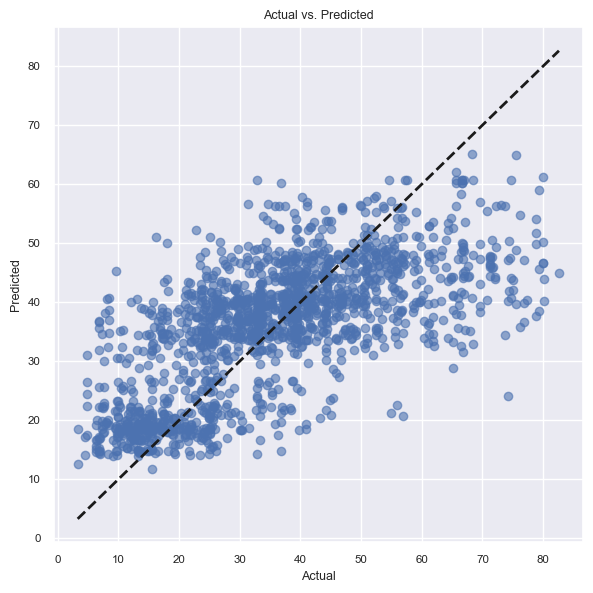

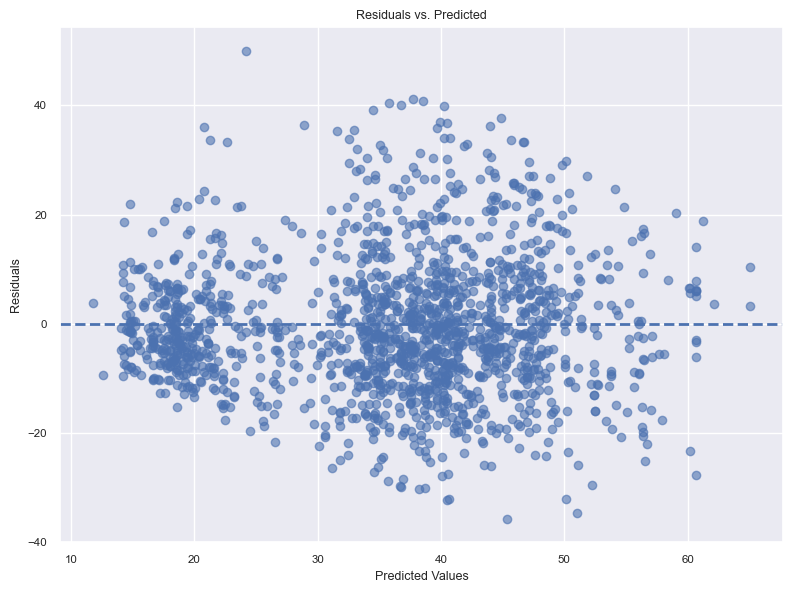

In [869]:
# fefine the pipeline for Random Forest
pipeline = Pipeline([
    ("scaler", RobustScaler()),
    ("feature_selection", SelectFromModel(
        estimator=Lasso(max_iter=10_000)
    )),
    ("regressor", RandomForestRegressor())
])

# init the combined hyperparameter grid
param_grid = {
    # lasso selector params
    "feature_selection__estimator__alpha": [0.01, 0.1, 1.0, 10.0],
    "feature_selection__threshold":     ["mean", "median"],
    "feature_selection__max_features":  [2, 4, 6, 8],

    # random Forest params
    "regressor__n_estimators":    [100, 200],
    "regressor__max_depth":       [None, 10, 20],
    "regressor__max_features":    ["sqrt", "log2"],
    "regressor__min_samples_split":[2, 5]
}

# gridSearchCV setup
grid_rf = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=5,
    n_jobs=-1
)

# fit on training data
grid_rf.fit(X_train, y_train)

# print the best params
print("Best params:", grid_rf.best_params_)

# selected features
selected_features = grid_rf.best_estimator_.named_steps["feature_selection"].get_support(indices=True)
print("Selected features:", X.columns[selected_features].tolist())

# evaluate on test set
y_pred    = grid_rf.predict(X_test)
test_r2   = r2_score(y_test, y_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Test  R²:   {test_r2:.3f}")
print(f"Test RMSE: {test_rmse:.3f}")

# plot actual vs. predicted
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'k--', lw=2)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs. Predicted")
plt.tight_layout()
plt.show()

# plot residuals vs. predicted
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, y_test - y_pred, alpha=0.6)
plt.axhline(0, linestyle="--", linewidth=2)
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs. Predicted")
plt.tight_layout()
plt.show()

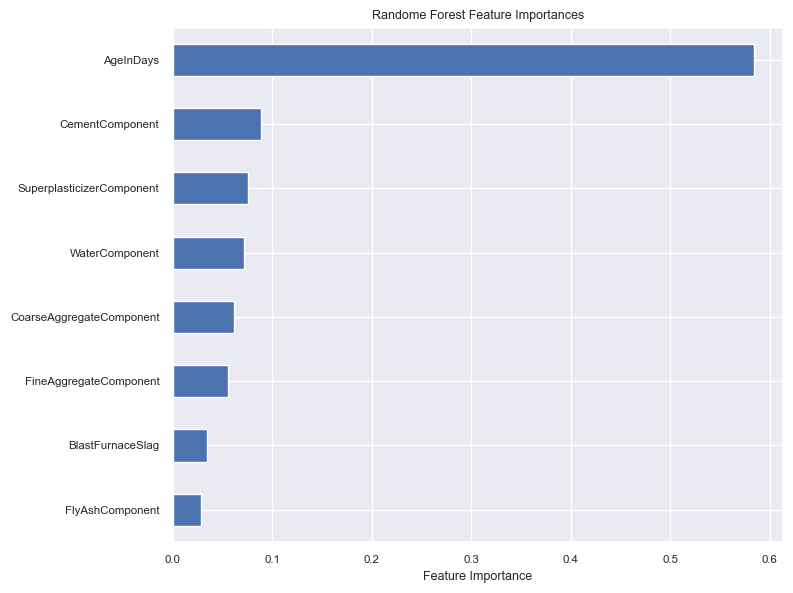

In [888]:
# getting the best fit pipeline
best_pipe = grid_rf.best_estimator_

# pulling out the mask of selected features
support_idx = best_pipe.named_steps["feature_selection"].get_support(indices=True)
selected_feature_names = X.columns[support_idx]

# getting the fitted XGBRegressor
best_rf = best_pipe.named_steps["regressor"]

# extract raw importances
importances = best_rf.feature_importances_

# create a series
fi_series = pd.Series(importances, index=selected_feature_names)
fi_series = fi_series.sort_values(ascending=True)

# horizontal bar chart
plt.figure(figsize=(8,6))
fi_series.plot(kind="barh")
plt.xlabel("Feature Importance")
plt.title("Randome Forest Feature Importances")
plt.tight_layout()
plt.savefig('df_concrete_rf_importance.png', bbox_inches='tight')
plt.show()

# XG Boost

Best params: {'feature_selection__estimator__alpha': 10.0, 'feature_selection__max_features': 8, 'feature_selection__threshold': 'mean', 'regressor__colsample_bytree': 0.8, 'regressor__learning_rate': 0.1, 'regressor__max_depth': 3, 'regressor__n_estimators': 100, 'regressor__subsample': 1.0}
Selected features: ['CementComponent', 'BlastFurnaceSlag', 'FlyAshComponent', 'WaterComponent', 'SuperplasticizerComponent', 'CoarseAggregateComponent', 'FineAggregateComponent', 'AgeInDays']
Test  R²:   0.456
Test RMSE: 12.381


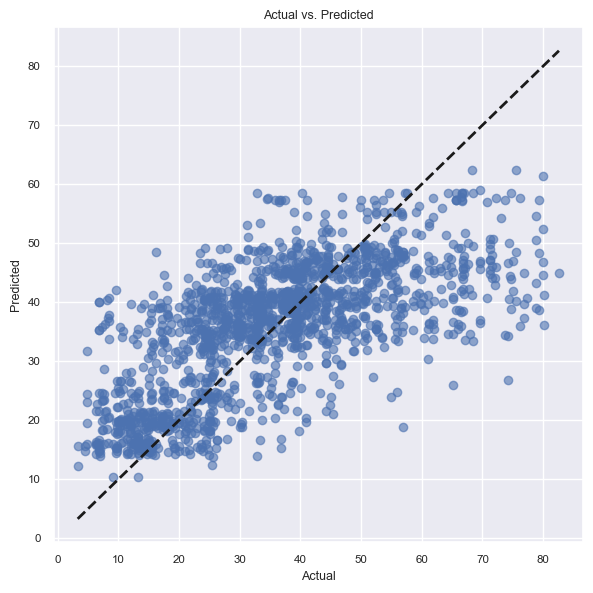

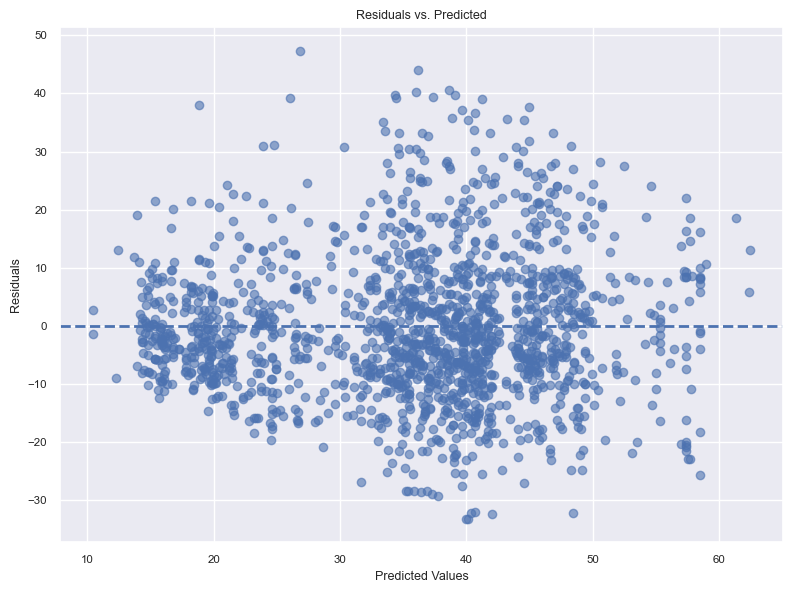

In [874]:
# pipeline definition
pipeline = Pipeline([
    ("scaler", RobustScaler()),
    ("feature_selection", SelectFromModel(
        estimator=Lasso(max_iter=10_000)
    )),
    ("regressor", XGBRegressor(
        objective="reg:squarederror"
    ))
])

# hyperparameter grid
param_grid = {
    # lasso selector params
    "feature_selection__estimator__alpha": [0.01, 0.1, 1.0, 10.0],
    "feature_selection__threshold":     ["mean", "median"],
    "feature_selection__max_features":  [2, 4, 6, 8],
    

    # xGBoost params
    "regressor__n_estimators":      [100, 200],
    "regressor__max_depth":         [3, 5, 7],
    "regressor__learning_rate":     [0.01, 0.1, 0.2],
    "regressor__subsample":         [0.8, 1.0],
    "regressor__colsample_bytree":  [0.8, 1.0]
}

# gridSearchCV setup
grid_xgb = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=5,
    n_jobs=-1
)

# ft on training data
grid_xgb.fit(X_train, y_train)

# best‐fit summary
print("Best params:", grid_xgb.best_params_)

# selected features
selected_features = grid_xgb.best_estimator_.named_steps["feature_selection"].get_support(indices=True)
print("Selected features:", X.columns[selected_features].tolist())

# evaluate on test set
y_pred    = grid_xgb.predict(X_test)
test_r2   = r2_score(y_test, y_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Test  R²:   {test_r2:.3f}")
print(f"Test RMSE: {test_rmse:.3f}")

# plot actual vs. predicted
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'k--', lw=2)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs. Predicted")
plt.tight_layout()
plt.show()

# plot residuals vs. predicted
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, y_test - y_pred, alpha=0.6)
plt.axhline(0, linestyle="--", linewidth=2)
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs. Predicted")
plt.tight_layout()
plt.show()

# Features Of the Best Model(XGBoost)

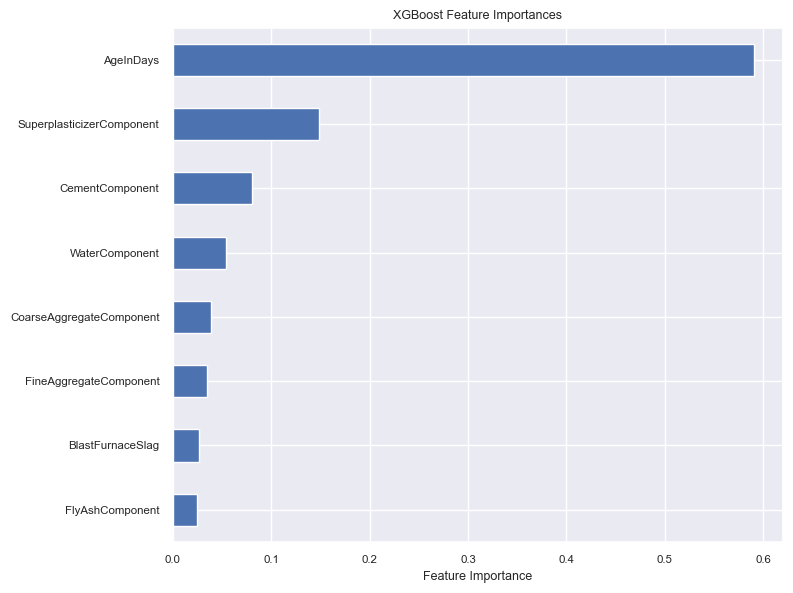

In [886]:
# getting the best fit pipeline
best_pipe = grid_xgb.best_estimator_

# pulling out the mask of selected features
support_idx = best_pipe.named_steps["feature_selection"].get_support(indices=True)
selected_feature_names = X.columns[support_idx]

# getting the fitted XGBRegressor
best_xgb = best_pipe.named_steps["regressor"]

# extract raw importances
importances = best_xgb.feature_importances_

# create a series
fi_series = pd.Series(importances, index=selected_feature_names)
fi_series = fi_series.sort_values(ascending=True)

# horizontal bar chart
plt.figure(figsize=(8,6))
fi_series.plot(kind="barh")
plt.xlabel("Feature Importance")
plt.title("XGBoost Feature Importances")
plt.tight_layout()
plt.savefig('df_concrete_xgb_importance.png', bbox_inches='tight')
plt.show()

# Ensemble Models

In [879]:
# grab the best pipelines
gbt_pipe = grid_gbt.best_estimator_
rf_pipe  = grid_rf.best_estimator_
xgb_pipe = grid_xgb.best_estimator_

# build a VotingRegressor 
voter = VotingRegressor([
    ("gbt", gbt_pipe),
    ("rf",  rf_pipe),
    ("xgb", xgb_pipe)
])

# fit it on your training data
voter.fit(X_train, y_train)

# evaluate on test set
y_pred = voter.predict(X_test)
print("VotingRegressor R²:", r2_score(y_test, y_pred))
print("VotingRegressor RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

VotingRegressor R²: 0.4583223647567176
VotingRegressor RMSE: 12.354892970470113


In [880]:
# specify the base learners
base_learners = [
    ("gbt", gbt_pipe),
    ("rf",  rf_pipe),
    ("xgb", xgb_pipe)
]

# choose a simple meta‐learner (here: Ridge with built-in CV)
stack = StackingRegressor(
    estimators=base_learners,
    final_estimator=RidgeCV(alphas=[0.1, 1.0, 10.0]),
    cv=5,
    n_jobs=-1,
    passthrough=True
)

# fit & evaluate
stack.fit(X_train, y_train)
y_pred = stack.predict(X_test)

print("StackingRegressor R²:",  r2_score(y_test, y_pred))
print("StackingRegressor RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

StackingRegressor R²: 0.4586551911093889
StackingRegressor RMSE: 12.351096740445843
